# Q-Learning Algorithms and their Application to Optimal Trading Problems:
## The Q-learning implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, seed

import xarray as xr

In [2]:
%precision 4
%config InlineBackend.figure_format = "retina"

## The Ornstein-Uhlenbeck process

In [21]:
# Going from (kappa, theta, sigma) -> (alpha, beta, gamma)
# does not seem to work properly (variance is way too low)
dt = 1 / 60
kappa, theta, sigma = 1e-5, 1, 2

alpha = theta * (1 - np.exp(-kappa * dt))
beta = np.exp(-kappa * dt)
gamma = np.sqrt(sigma ** 2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa))

$$
    X_{t_i + 1} = \alpha + \beta X_{t_i}
$$

In [22]:
alpha, beta, gamma

(1.6666665281217519e-07, 0.9999998333333472, 0.25819886822283034)

In [279]:
timesteps = 500
t = np.linspace(0, 2, timesteps)

alpha, beta = .08, 0.98
gamma = .2
e_t = randn(timesteps) * gamma

In [275]:
seed(314)
x0 = 1.5
X = np.zeros(timesteps)
for t in range(timesteps):
    if t == 0:
        X[t] = x0
    else:
        X[t] = alpha + beta * X[t-1] + e_t[t-1]
X = X

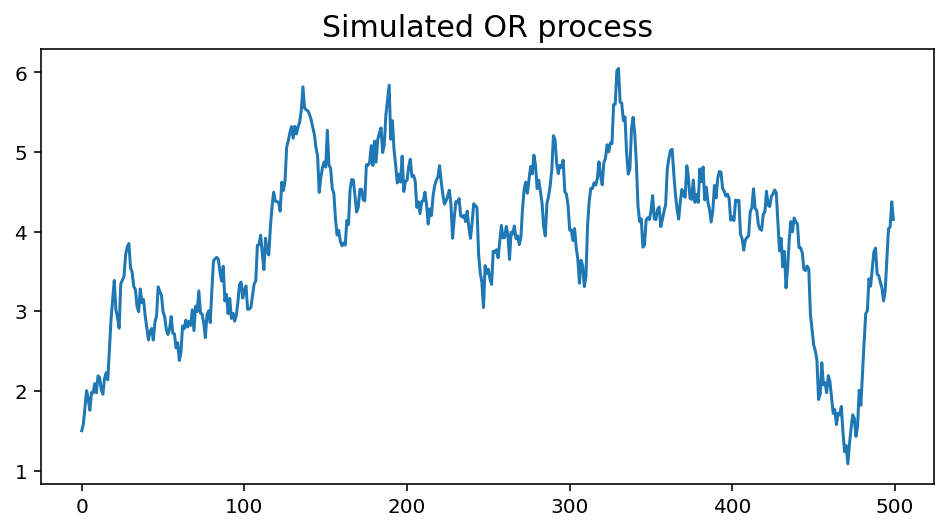

In [276]:
plt.figure(figsize=(8, 4))
plt.title("Simulated OR process", fontsize=15)
plt.plot(X);

We consider a three-tuple state that takes us to a single action

```
* T: terminal time (0, T)
* N: intermediate trading periods
* A: Number of shares traded at a single period
* Q: Current inventory
```

In [277]:
T, N, A, Q = 1, 1, 1, 1
Q = np.zeros((T, N, A, Q))

In [280]:
sigma = np.sqrt(2 * gamma ** 2 * np.log(beta) / (beta ** 2 - 1))
sigma

0.20202363756848574

In [281]:
n = 3.5
xmin, xmax = theta + np.array([-1, 1]) *  n * sigma / np.sqrt(2 * kappa)
xmin, xmax

(0.5000170057037263, 1.4999829942962737)

In [291]:
# When we simulate our price path, we bin our observations
# into into intervals degined by the grid-points
M = 100
delta_x = (xmax - xmin) / M
bins = np.arange(M) * delta_x + xmin

## Implementation

* To-do: Correct OU process

$$
    \alpha = \theta(1 - \exp(-\kappa\Delta))  
$$

$$
    \beta = \exp(-\kappa \Delta)
$$

$$
    \gamma^2 = \frac{\sigma^2}{2\kappa} (1 - \exp(-2\kappa\Delta))
$$

In [23]:
def simulate_or_process(x0, alpha, beta, gamma, timesteps):
    e_t = randn(timesteps) * gamma
    X = np.zeros(timesteps)
    for t in range(timesteps):
        if t == 0:
            X[t] = x0
        else:
            X[t] = alpha + beta * X[t-1] + e_t[t-1]
    return X

In [26]:
def simulate_OU_process(x0, xbar, kappa, sigma, T=1, timesteps=1000):
    dt =1 / timesteps  # Time step.
    n = int(T / dt)  # Number of time steps.
    t = np.linspace(0, T, n)
    sqrtdt = np.sqrt(dt)
    x = np.zeros(n)
    x[0]=x0
    errs = randn(n - 1)
    for i in range(n - 1):
        x[i + 1] = (x[i] + dt * ((xbar - x[i]) * kappa) +
                    sqrtdt * sigma* errs[i])

    return t, x

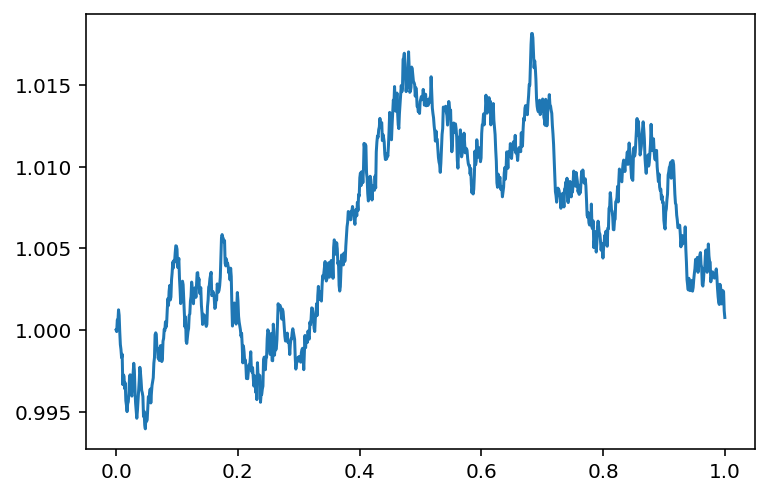

In [35]:
plt.plot(*simulate_OU_process(1, 1, 1, 0.02))

Reward at time $t_i$


$$
    R_i = q_{t_i} (X_{t_{i+1}} - X_{t_{i}}) - \phi a_{t_i}^2
$$

In [171]:
timesteps = 1000
M = 100
inventory = 101
action = 11
S = np.zeros((M, timesteps, inventory, action))
S.shape, sum(S.shape)

((100, 1000, 101, 11), 1212)

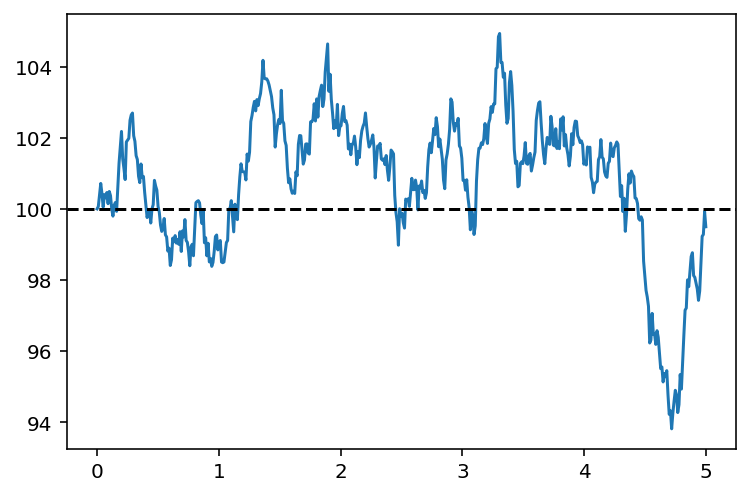

In [229]:
kappa, xbar, sigma = 1, 100, 4
x0 = 100
seed(314)
t, Xt = simulate_OU_process(x0, xbar, kappa, sigma, T=5, timesteps=100)
plt.plot(t, Xt)
plt.axhline(y=xbar, c="black", linestyle="--")

In [222]:
np.set_printoptions(suppress=True)

In [232]:
t = t.round(4)

In [235]:
sell_min, buy_max = 5, 5
phi = 0.01
Qmin, Qmax = -10, 10
bucket_size = 0.1
xmin, xmax = 90, 110
Δx = np.arange(xmin, xmax, 0.1)
inventory = np.arange(-50, 50)
actions = np.arange(-sell_min, buy_max)

In [236]:
Δx = np.round(Δx, 1)

In [237]:
dimensions = ["time", "price", "inventory", "actions"]
Q = xr.DataArray(0, coords=[t, Δx, inventory, actions], dims=dimensions)
Q

<xarray.DataArray (time: 500, price: 200, inventory: 100, actions: 10)>
array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
...
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]])
Coordinates:
  * time       (time) float64 0.0 0.01 0.02 0.0301 0.0401 ... 4.97 4.98 4.99 5.0
  * price      (price) float64 90.0 90.1 90.2 90.3 ... 109.6 109.7 109.8 109.9
  * inventory  (inventory) int64 -50 -49 -48 -47 -46 -45 ... 44 45 46 47 48 49
  * actions    (actions) int64 -5 -4 -3 -2 -1 0 1 2 3 4

Reward at time $t_i$


$$
    R_i = \mathbb{E}\left[(q_{t_i} + a_{t_i})  (X_{t_{i+1}} - X_{t_{i}}) - \phi a_{t_i}^2\right]
$$

In [238]:
Xt[1] - Xt[0]

0.06643417549621233

In [269]:
class QTrading:
    def __init__(self, kappa, sigma, xbar, phi, gamma=0.2, T=1, dt=0.01):
        self.kappa = kappa
        self.sigma = sigma
        self.xbar = xbar
        self.phi = phi
        self.gamma = gamma
        self.T = T
        self.dt = dt
        
    def next_price(self, price):
        price = (price * np.exp(-self.kappa * self.dt) +
                 self.xbar * (1-np.exp(-self.kappa*self.dt)) +
                 np.sqrt(self.sigma ** 2 / (2 * self.kappa) * (1 - np.exp(-2*self.kappa*self.dt))) 
                 * np.random.randn())

        return price
        
    def step(self, time, inventory, price, action):
        q_new = inventory + action
        new_price = self.next_price(price)
        t_new = time + self.dt
        if t_new < self.T:
            r = q_new * (new_price-price) - self.phi * action**2
        else:
            r = q_new * (new_price-price) - self.phi * action ** 2 - c * q_new** 2
        
        new_price = np.round(new_price, 1)
        return r, t_new, q_new, new_price

In [241]:
qtrading = QTrading(kappa=1, sigma=4, xbar=100, phi=.01)

In [242]:
reward_new, t_new, inventory_new, price_new = qtrading.step(0, 0, 100, 10)

In [243]:
learning_rate = 0.01

In [244]:
Q.assign_attrs()

<xarray.DataArray (time: 500, price: 200, inventory: 100, actions: 10)>
array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
...
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]])
Coordinates:
  * time       (time) float64 0.0 0.01 0.02 0.0301 0.0401 ... 4.97 4.98 4.99 5.0
  * price      (price) float64 90.0 90.1 90.2 90.3 ... 109.6 109.7 109.8 109.9
  * inventory  (inventory) int64 -50 -49 -48 -47 -46 -45 ... 44 45 46 47 48 49
  * actions    (actions) int64 -5 -4 -3 -2 -1 0 1 2 3 4

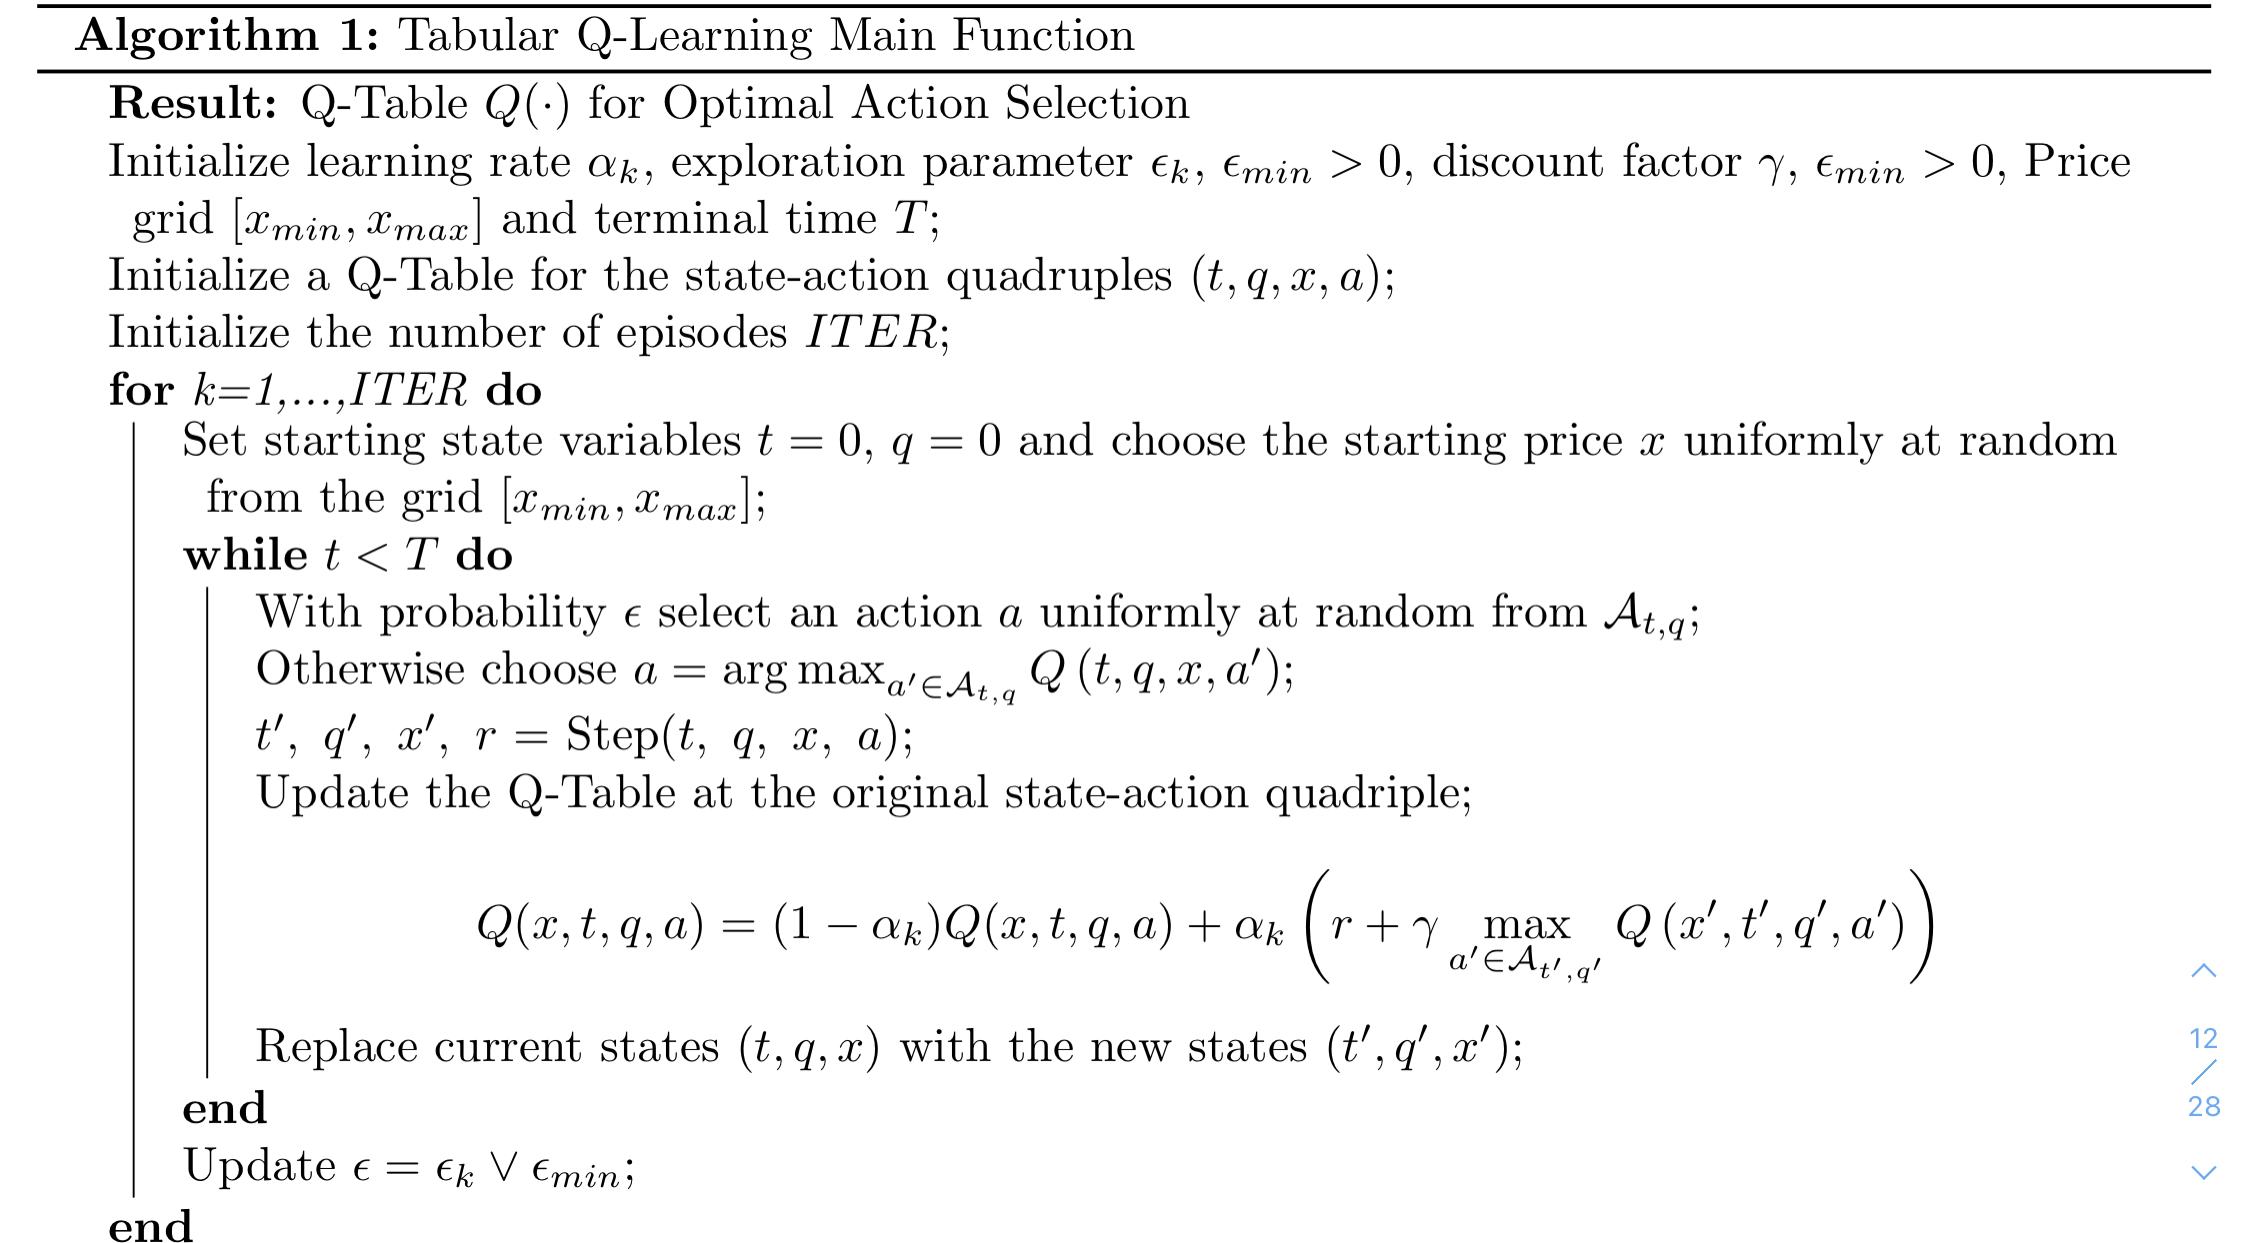

In [270]:
discount_factor = 0.8

In [271]:
Q_new_max = Q.sel(price=price_new, time=0.01, inventory=inventory_new).max().values

Q_update = (Q.sel(price=100, inventory=0, time=0, actions=0) * (1 - learning_rate) +
         learning_rate * (reward_new + discount_factor * Q_new_max))

In [279]:
Q[0, 100, 0, 0] = Q_update